# analyze `allblocks-quorum-raft.db` data

calculates & plots

* blocktime
* TPS (transactions per second), over 1, 3, 5, 10 consecutive blocks
* block size
* gasUsed and gasLimit per second

It needs an `allblocks-quorum-raft.db` database (created by `blocksDB_create.py`) containing all the blocks.

In this specific case the "`Quorum`" client of the EEA, with the `raft` consensus.

---

Please cite this as:

> Ethereum benchmarking scripts "chainhammer" and "chainreader"  
> by Dr Andreas Krueger, Electron.org.uk, London 2018  
> https://github.com/drandreaskrueger/chainhammer    

Consider to submit your improvements & usage as pull request --> [../other-projects.md](../other-projects.md).  Thanks.


---

<a id='chainhammer10000'>10000 transactions shot at the Quorum-Raft node</a>
# my own experiment: 
## 10,000 transactions submitted with `chainhammer` 

    


## TOC

Code 

* [import from database](#Database)
* [simple statistics](#stats)
* [generate new columns](#columns)
* [4 diagrams in one](#code4diagrams)

Results

* [tables of peak TPS rates](#tables)
* [all 3 consecutive experiments](#allExperiments)
* [experiment 1](#experiment 1)
* [experiment 3](#experiment 3)


<a id='database'>Database</a>

In [ ]:
# Settings

DBFILE="allblocks-quorum-raft.db"
RAFT = True
NAME_PREFIX="quorum-raft"


In [ ]:
#dependencies

import sqlite3; print("sqlite3 version", sqlite3.version)
import pandas; print("pandas version", pandas.__version__)
import numpy; print("numpy version", numpy.__version__)
import matplotlib; print("matplotlib version", matplotlib.__version__)

%matplotlib inline

# https://github.com/matplotlib/matplotlib/issues/5907#issuecomment-179001811
matplotlib.rcParams['agg.path.chunksize'] = 10000

print ("\nReading blocks table from", DBFILE)

sqlite3 version 2.6.0
pandas version 0.23.0
numpy version 1.14.4
matplotlib version 2.2.2

Reading blocks table from allblocks-quorum-raft.db


### TODO: refactoring
all the following functions could go into a separate `blocksDB_diagramming.py` for better recycling.

**For now, please simply scroll down.**

In [ ]:
# open database connection
conn = sqlite3.connect(DBFILE)

# any SQL query 

def DB_query(SQL, conn):
    cur = conn.cursor()
    cur.execute(SQL)
    result = cur.fetchall()
    return result

print ("DB table names: ", DB_query("SELECT name FROM sqlite_master WHERE type='table';", conn)[0])

# number of rows?

def DB_tableSize(tablename, conn):
    """
    prints number of rows
    """
    count = DB_query("SELECT COUNT(*) FROM %s" % tablename, conn)
    print ("TABLE %s has %d rows" % (tablename, count[0][0]))
    return count
_=DB_tableSize("blocks", conn)

# what is the first & last block we have?

def maxBlockNumber(conn):
    result = DB_query("SELECT MIN(blocknumber), MAX(blocknumber) FROM blocks", conn)
    print ("MIN(blocknumber), MAX(blocknumber) = %s " % (result) )
    return result
minblock, maxblock = maxBlockNumber(conn)[0]

DB table names:  ('blocks',)
TABLE blocks has 345 rows
MIN(blocknumber), MAX(blocknumber) = [(0, 344)] 


In [ ]:
blocknumbers = DB_query("SELECT blocknumber FROM blocks ORDER BY blocknumber", conn) 
print ("len(blocknumbers)=", len(blocknumbers))

len(blocknumbers)= 345


In [ ]:
# do we have consecutive blocks, none missing?

def check_whether_complete(blocknumbers):
    start = min(blocknumbers)[0]
    last = max(blocknumbers)[0]
    old = start-1
    total=0
    for bn in blocknumbers:
        bn = bn[0]
        missing=bn-old-1
        if missing>0:
            print ("from ", old+1, "to", bn - 1, "there are ", missing, " missing")
            total+=missing
        old = bn
    print()
    print ("complete" if not total else "some %d blocks missing" % total, end=" ")
    print ("between blocks %d and %d." %(min(blocknumbers)[0], max(blocknumbers)[0]))
    
check_whether_complete(blocknumbers)


complete between blocks 0 and 344.


<a id='stats'>simple statistics</a>

In [ ]:
# simple statistics

size_max = DB_query("SELECT MAX(size) FROM blocks", conn); print ("(block)size_max", size_max[0][0])
txcount_max = DB_query("SELECT MAX(txcount) FROM blocks", conn); print ("txcount_max", txcount_max[0][0])
txcount_av = DB_query("SELECT AVG(txcount) FROM blocks", conn); print ("txcount_av", txcount_av[0][0])
txcount_sum = DB_query("SELECT SUM(txcount) FROM blocks", conn); print ("txcount_sum", txcount_sum[0][0])
blocks_nonempty_count = DB_query("SELECT COUNT(blocknumber) FROM blocks WHERE txcount != 0", conn); print ("blocks_nonempty_count", blocks_nonempty_count[0][0])
print ("av tx per nonempty blocks = ", txcount_sum[0][0] / blocks_nonempty_count[0][0] )

(block)size_max 533189
txcount_max 3917
txcount_av 26.327536231884057
txcount_sum 9083
blocks_nonempty_count 344
av tx per nonempty blocks =  26.40406976744186


<a id='colums'>new columns</a>
## read whole table, and create new columns

In [ ]:
# read whole table

# SQL="SELECT * FROM blocks WHERE 48500<blocknumber and blocknumber<49000 ORDER BY blocknumber"
SQL="SELECT * FROM blocks ORDER BY blocknumber"
df = pandas.read_sql(SQL, conn)

In [ ]:
conn.close()

### RAFT consensus returns a nanosecond timestamp ???

In [ ]:
# quorum raft uses nanoseconds, not seconds --> transform nanoseconds to seconds
if RAFT:
    df["timestamp"]=df["timestamp"]/1000000000
    print ("corrected timestamps because RAFT")
df[:10]

corrected timestamps because RAFT


,blocknumber,timestamp,size,gasUsed,gasLimit,txcount
0,0,0.000000e+00,537,0,3758096384,0
1,1,1.529327e+09,913,95173,3754426369,1
2,2,1.529327e+09,653,41691,3750760077,1
3,3,1.529327e+09,788,53382,3747097288,2
4,4,1.529327e+09,1325,160146,3743438093,6
5,5,1.529327e+09,1057,106764,3739782627,4
6,6,1.529327e+09,1057,106764,3736130653,4
7,7,1.529327e+09,2263,346983,3732482245,13
8,8,1.529327e+09,2665,427056,3728837752,16
9,9,1.529327e+09,3201,533820,3725196935,20


In [ ]:
# blocktime = timestamp[n] - timestamp[n-1]

def add_blocktime(df):
    df['blocktime'] = df['timestamp'] - df['timestamp'].shift()
    df.loc[1, "blocktime"] = numpy.nan
    
add_blocktime(df)
df[0:10]

,blocknumber,timestamp,size,gasUsed,gasLimit,txcount,blocktime
0,0,0.000000e+00,537,0,3758096384,0,NaN
1,1,1.529327e+09,913,95173,3754426369,1,NaN
2,2,1.529327e+09,653,41691,3750760077,1,6.977993
3,3,1.529327e+09,788,53382,3747097288,2,0.030022
4,4,1.529327e+09,1325,160146,3743438093,6,0.038960
5,5,1.529327e+09,1057,106764,3739782627,4,0.164823
6,6,1.529327e+09,1057,106764,3736130653,4,0.050258
7,7,1.529327e+09,2263,346983,3732482245,13,0.063486
8,8,1.529327e+09,2665,427056,3728837752,16,0.041128
9,9,1.529327e+09,3201,533820,3725196935,20,0.063481


In [ ]:
#df["TPS_1"]=df['txcount']/df['blocktime']
#df

In [ ]:
# transactions per second
# with differently sized (rectangular) windows

def add_TPS(df, numBlocks):
    name = 'TPS_%dblks'%numBlocks if numBlocks>1 else 'TPS_%dblk'%numBlocks
    df[name]=df['txcount'].rolling(numBlocks).sum() / df['blocktime'].rolling(numBlocks).sum()
    
add_TPS(df, numBlocks=1)
add_TPS(df, numBlocks=3)
add_TPS(df, numBlocks=5)
add_TPS(df, numBlocks=10)

In [ ]:
# gasUsed and gasLimit per second

def add_GUPS(df, numBlocks):
    name = 'GUPS_%dblks'%numBlocks if numBlocks>1 else 'GUPS_%dblk'%numBlocks
    df[name]=df['gasUsed'].rolling(numBlocks).sum() / df['blocktime'].rolling(numBlocks).sum()

def add_GLPS(df, numBlocks):
    name = 'GLPS_%dblks'%numBlocks if numBlocks>1 else 'GLPS_%dblk'%numBlocks
    df[name]=df['gasLimit'].rolling(numBlocks).sum() / df['blocktime'].rolling(numBlocks).sum()

add_GUPS(df, numBlocks=1)
add_GUPS(df, numBlocks=3)
add_GUPS(df, numBlocks=5)

add_GLPS(df, numBlocks=1)
add_GLPS(df, numBlocks=3)
add_GLPS(df, numBlocks=5)

<a id='tables'>tables of peak TPS rates</a>
## peak TPS rates

In [ ]:
# peak TPS single block

df.sort_values(by=['TPS_1blk'], ascending=False)[0:7]

,blocknumber,timestamp,size,gasUsed,gasLimit,txcount,blocktime,TPS_1blk,TPS_3blks,TPS_5blks,TPS_10blks,GUPS_1blk,GUPS_3blks,GUPS_5blks,GLPS_1blk,GLPS_3blks,GLPS_5blks
294,294,1.529327e+09,8547,1574769,2819931107,59,0.020056,2941.726730,512.151086,229.665676,266.187199,7.851763e+07,1.366982e+07,6.130007e+06,1.406011e+11,6.023512e+10,3.909088e+10
337,337,1.529327e+09,2291,346983,2703942085,13,0.006354,2045.925181,285.535844,145.898803,295.313241,5.460779e+07,7.621237e+06,3.894185e+06,4.255433e+11,1.104039e+11,7.058462e+10
80,80,1.529327e+09,3104,507129,3475580621,19,0.010016,1896.881272,271.070740,263.156683,252.475324,5.062966e+07,7.235149e+06,7.023915e+06,3.469876e+11,6.900361e+10,8.182249e+10
299,299,1.529327e+09,7731,1414623,2806193970,53,0.038152,1389.198233,316.649608,208.938672,216.667119,3.707909e+07,8.451695e+06,5.576782e+06,7.355396e+10,3.867169e+10,2.312872e+10
332,332,1.529327e+09,3787,640584,2717182163,24,0.019234,1247.763198,347.684262,351.644532,266.788355,3.330405e+07,9.280041e+06,9.385744e+06,1.412667e+11,4.052764e+10,2.674165e+10
32,32,1.529327e+09,6097,1094331,3642436162,41,0.035076,1168.877754,728.747111,656.919946,264.015047,3.119852e+07,1.945099e+07,1.753385e+07,1.038430e+11,1.811598e+11,1.393879e+11
30,30,1.529327e+09,792,53382,3649560610,2,0.001926,1038.451102,607.212132,191.441528,258.508321,2.771730e+07,1.620710e+07,5.109766e+06,1.894945e+12,1.512426e+11,3.017433e+10


In [ ]:
# peak TPS over ten blocks

df.sort_values(by=['TPS_10blks'], ascending=False)[0:7]

,blocknumber,timestamp,size,gasUsed,gasLimit,txcount,blocktime,TPS_1blk,TPS_3blks,TPS_5blks,TPS_10blks,GUPS_1blk,GUPS_3blks,GUPS_5blks,GLPS_1blk,GLPS_3blks,GLPS_5blks
60,60,1.529327e+09,2969,480438,3544153519,18,0.041548,433.231221,382.216193,237.249374,366.456672,1.156337e+07,1.020173e+07,6.332423e+06,8.530211e+10,7.264057e+10,7.020779e+10
182,182,1.529327e+09,4601,800730,3145962280,30,0.056733,528.795986,318.622653,263.004743,334.784898,1.411409e+07,8.504357e+06,7.019860e+06,5.545241e+10,6.020129e+10,6.280470e+10
55,55,1.529327e+09,5553,987567,3561506668,37,0.042282,875.084571,419.226027,500.513604,332.876598,2.335688e+07,1.118956e+07,1.335921e+07,8.423296e+10,7.005638e+10,7.319960e+10
59,59,1.529327e+09,2017,293601,3547617558,11,0.049952,220.212321,341.123046,311.475101,320.723995,5.877687e+06,9.104915e+06,8.313582e+06,7.102083e+10,9.085179e+10,7.007320e+10
280,280,1.529327e+09,2019,293601,2858761683,11,0.049714,221.266307,242.397056,310.586541,317.117971,5.905819e+06,6.469820e+06,8.289865e+06,5.750433e+10,5.780274e+10,5.702757e+10
183,183,1.529327e+09,1202,133455,3142891225,5,0.046207,108.208827,313.025157,242.206394,316.178808,2.888202e+06,8.354954e+06,6.464731e+06,6.801771e+10,6.285739e+10,6.251784e+10
58,58,1.529327e+09,4193,720657,3551084357,27,0.055014,490.785100,192.071284,360.856533,311.440050,1.309955e+07,5.126575e+06,9.631622e+06,6.454886e+10,6.607048e+10,8.126199e+10


In [ ]:
# peak TPS over ten blocks

df.sort_values(by=['size'], ascending=False)[0:5]

,blocknumber,timestamp,size,gasUsed,gasLimit,txcount,blocktime,TPS_1blk,TPS_3blks,TPS_5blks,TPS_10blks,GUPS_1blk,GUPS_3blks,GUPS_5blks,GLPS_1blk,GLPS_3blks,GLPS_5blks
343,343,1.529327e+09,533189,104548647,2688141798,3917,15.426582,253.912369,251.875063,251.371080,251.126827,6.777175e+06,6.722797e+06,6.709346e+06,1.742539e+08,5.093219e+08,8.456694e+08
344,344,1.529327e+09,24864,4777689,2685669808,179,9.018622,19.847822,166.537675,167.688835,168.170059,5.297582e+05,4.445057e+06,4.475783e+06,2.977916e+08,3.266188e+08,5.401213e+08
218,218,1.529327e+09,12626,2375499,3037249095,89,0.264958,335.902717,258.847237,301.701435,248.214225,8.965579e+06,6.908892e+06,8.052713e+06,1.146315e+10,2.459226e+10,3.350859e+10
18,18,1.529327e+09,12130,2295426,3692588155,86,0.377707,227.689571,208.892578,207.285749,208.759155,6.077262e+06,5.575552e+06,5.532664e+06,9.776323e+09,1.914318e+10,2.883153e+10
294,294,1.529327e+09,8547,1574769,2819931107,59,0.020056,2941.726730,512.151086,229.665676,266.187199,7.851763e+07,1.366982e+07,6.130007e+06,1.406011e+11,6.023512e+10,3.909088e+10


<a id='code4diagrams'>code: 4 diagrams in one</a>
## all 4 diagrams in one

In [ ]:
def diagrams(df, blockFrom, blockTo, prefix="", gas_logy=True, bt_logy=True, tps_logy=False):
    
    # https://github.com/matplotlib/matplotlib/issues/5907#issuecomment-179001811
    matplotlib.rcParams['agg.path.chunksize'] = 10000
    
    # prepare 2x2 subplots
    plt = matplotlib.pyplot
    fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(15,10))
    plt.tight_layout(pad=6.0, w_pad=6.0, h_pad=7.5)
    title = prefix + " blocks %d to %d" % (blockFrom, blockTo)
    plt.suptitle(title, fontsize=16)
    
    # bar charts are too expensive when too many blocks
    numBlocks =  blockTo - blockFrom
    kind = 'bar' if numBlocks<2000 else 'line'
    
    # TPS averages --> legend
    cols=['TPS_1blk', 'TPS_3blks', 'TPS_5blks', 'TPS_10blks']
    averages=df[cols][blockFrom:blockTo].mean()
    legend = [col + " (av %.1f)" % averages[col] for col in cols]
    # print (legend)
    
    # TPS diagram
    cols = ['blocknumber'] + cols
    ax=df[cols][blockFrom:blockTo].plot(x='blocknumber', rot=90, ax=axes[0,0],  logy=tps_logy)
    ax.set_title("transactions per second")
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    ax.legend(legend);
    
    # BT
    ax=df[['blocknumber', 'blocktime']][blockFrom:blockTo].plot(x='blocknumber', kind=kind, ax=axes[0,1],
                                                               logy=bt_logy)
    ax.set_title("blocktime since last block")
    ax.locator_params(nbins=10, axis='x')
        
    # blocksize
    ax=df[['blocknumber', 'size']][blockFrom:blockTo].plot(x='blocknumber', rot=90, kind=kind, ax=axes[1,0])
    # ax.get_xaxis().get_major_formatter().set_useOffset(False)
    ax.get_yaxis().get_major_formatter().set_scientific(False)
    ax.set_title("blocksize in bytes")
    ax.locator_params(nbins=10, axis='x')
    
    # gas
    ax=df[['blocknumber', 'GLPS_1blk', 'GUPS_1blk']][blockFrom:blockTo].plot(x='blocknumber', 
                                                                             rot=90, ax=axes[1,1], 
                                                                             logy=gas_logy)
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    if not gas_logy:
        ax.get_yaxis().get_major_formatter().set_scientific(False)
    ax.set_title("gasUsed and gasLimit per second")
    
    # save diagram to PNG file
    fig.savefig("img/%s_tps-bt-bs-gas_blks%d-%d.png" % (prefix,blockFrom,blockTo))


# <a id='allExperiments'>all 3 experiments</a>
## all experiments - whole chain DB

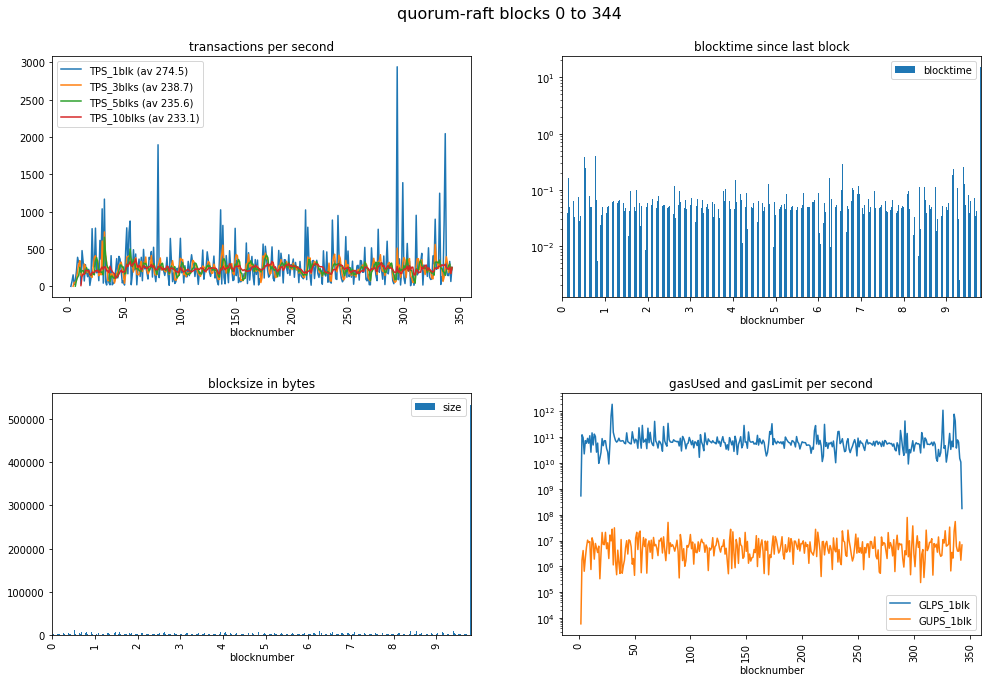

In [ ]:
# the whole range of blocks

diagrams(df, 0, len(blocknumbers)-1, NAME_PREFIX, gas_logy=True, bt_logy=True)

<a id='logplots'>same data plotted differently</a>

# log plot + all but the last block

the last block is very large (0.5 megabyte, 3917 transactions), so I leave it out from the following plots.

plus

TPS is fluctuating much, so we look at TPS on a logarithmic scale


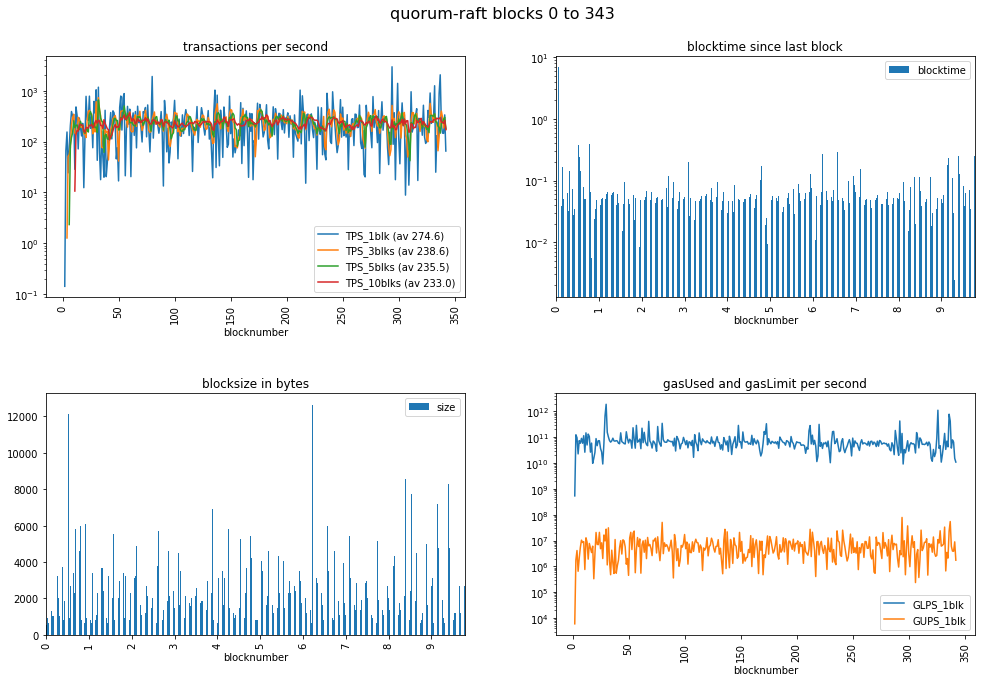

In [ ]:
# starting only at block 3 because the waiting time before experiment start created a 100s *blocktime*

diagrams(df, 0, len(blocknumbers)-2, NAME_PREFIX, gas_logy=True, bt_logy=True, tps_logy=True)